In [1]:
import numpy as np
import re
import itertools
from collections import Counter
import collections
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import ndarray as nd
from mxnet import autograd
import pickle
from mxnet.contrib import text


定义一些辅助函数

In [2]:
def review_to_wordlist(review):
    string = review.lower()
    string = re.findall(r'(?u)\b\w\w+\b',string)
    return string
def build_input_data(x,y,vocab,max_length,padding_word='</s>'):
    padded_sentences = []
    for i in range(len(x)):
        sentence = x[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(vocab.to_indices(new_sentence))
    xd = np.array(padded_sentences)
    yd = np.array(y)
    return xd,yd

构建网络模型，以及准确率函数

In [3]:
class ConvConcat(nn.HybridBlock):
    def __init__(self,sentence_size,num_embed,**kwargs):
        super(ConvConcat,self).__init__(**kwargs)
        net1 = nn.HybridSequential()
        with net1.name_scope():
            net1.add(nn.Conv2D(channels=100,kernel_size=(3,num_embed),activation='relu'))
            net1.add(nn.MaxPool2D(pool_size=(sentence_size-3+1,1)))

        net2 = nn.HybridSequential()
        with net2.name_scope():
            net2.add(nn.Conv2D(channels=100,kernel_size=(4,num_embed),activation='relu'))
            net2.add(nn.MaxPool2D(pool_size=(sentence_size-4+1,1)))
        
        net3 = nn.HybridSequential()
        with net3.name_scope():
            net3.add(nn.Conv2D(channels=100,kernel_size=(5,num_embed),activation='relu'))
            net3.add(nn.MaxPool2D(pool_size=(sentence_size-5+1,1)))
            
        net4 = nn.HybridSequential()
        with net4.name_scope():
            net4.add(nn.Conv2D(channels=100,kernel_size=(6,num_embed),activation='relu'))
            net4.add(nn.MaxPool2D(pool_size=(sentence_size-6+1,1)))
        
        self.net1 = net1
        self.net2 = net2
        self.net3 = net3
        self.net4 = net4
    def hybrid_forward(self,F,x):
        pooled_outputs = []
        pooled_outputs.append(self.net1(x))
        pooled_outputs.append(self.net2(x))
        pooled_outputs.append(self.net3(x))
        pooled_outputs.append(self.net4(x))
        
        total_filters = 100 * 4
        concat = F.Concat(*pooled_outputs, dim=1)
        h_pool = F.reshape(concat, (-1, total_filters))
        
        return h_pool

class ReshapeInput(nn.HybridBlock):
    def __init__(self,sentence_size,num_embed,**kwargs):
        super(ReshapeInput,self).__init__(**kwargs)
        self.sentence_size = sentence_size
        self.num_embed = num_embed
    def hybrid_forward(self,F,x):
        return F.reshape(x,(-1,1,self.sentence_size,self.num_embed))

def accuracy(output, label):
    return np.mean(output.argmax(axis=1)==label)

def get_valid_acc(net,valid):
    valid_acc = 0.
    for data,label in valid:
        output = net(data.as_in_context(mx.gpu()))
        valid_acc +=accuracy(nd.softmax(output).asnumpy(),label.asnumpy())
    return valid_acc/len(valid)

数据处理

In [4]:
train_data,train_label = pickle.load(open('./train','rb'))

In [5]:
test_data,test_label = pickle.load(open('./test','rb'))

In [6]:
sequence_length = 400

In [7]:
td = []
for d in train_data:
    rad = review_to_wordlist(d)
    if len(rad) > sequence_length:
        rad = rad[:sequence_length]
    td.append(rad)
tsd = []
for d in test_data:
    rad = review_to_wordlist(d)
    if len(rad) > sequence_length:
        rad = rad[:sequence_length]
    tsd.append(rad)

del train_data
del test_data
train_data = td
test_data = tsd
del td
del tsd

创建词典

In [8]:
fr_vocab = text.vocab.Vocabulary(Counter(itertools.chain(*train_data)),reserved_tokens=['</s>'])

In [9]:
my_embedding = text.embedding.create('fasttext', pretrained_file_name='wiki.simple.vec', vocabulary=fr_vocab,)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/mxnet/contrib/text/embedding.py:278: UserWarning: At line 1 of the pre-trained text embedding file: token 111051 with 1-dimensional vector [300.0] is likely a header and is skipped.
  'skipped.' % (line_num, token, elems))


In [10]:
fr_vocab_lable = text.vocab.Vocabulary(Counter(test_label),unknown_token=None)

In [11]:
train_labels = fr_vocab_lable.to_indices(train_label)
test_labels = fr_vocab_lable.to_indices(test_label)

In [12]:
train_data, train_labels = build_input_data(train_data, train_labels, my_embedding,sequence_length)
train_labels = train_labels -1

In [13]:
test_data, test_labels = build_input_data(test_data, test_labels, my_embedding,sequence_length)
test_labels = test_labels -1

In [14]:
embed_size = my_embedding.vec_len
sentence_size = sequence_length
vocab_size = len(my_embedding)

In [15]:
shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
train_x = nd.array(train_data[shuffle_indices])
train_y = nd.array(train_labels[shuffle_indices])
del train_data
del train_labels

In [16]:
test_x = nd.array(test_data)
test_y = nd.array(test_labels)
del test_data
del test_labels

构建模型以及开始训练

In [17]:
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_x,train_y), batch_size=8,shuffle=True)
valid_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_x,test_y), batch_size=8,shuffle=True)

In [18]:
net = nn.HybridSequential()
with net.name_scope():
    net.add(nn.Embedding(len(my_embedding), my_embedding.vec_len))
    net.add(ReshapeInput(sentence_size,300))
    net.add(ConvConcat(sentence_size,300))
    net.add(nn.Dropout(.5))
    net.add(nn.Dense(20))
net.initialize(ctx = mx.gpu())
net[0].weight.set_data(my_embedding.idx_to_vec)
net.hybridize()

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'Adam')


In [19]:
Max_valid_acc = 0.85
loss_array = []
valid_acc_array = []
train_acc_array = []
for epoch in range(7):
    train_loss = 0.
    train_acc = 0.
    valid_acc = 0.
    for i,(data, label) in enumerate(train_data):
        with autograd.record():
            output = net(data.as_in_context(mx.gpu()))
            loss = softmax_cross_entropy(output, label.astype('float32').as_in_context(mx.gpu()))
        loss.backward()
        trainer.step(8)

        _loss = nd.mean(loss).asscalar()
        train_loss += _loss
        _acc = accuracy(nd.softmax(output).asnumpy(), label.asnumpy())
        train_acc += _acc

        if i % 50 == 49:
            valid_acc = get_valid_acc(net,valid_data)
            if valid_acc > Max_valid_acc:
                Max_valid_acc = valid_acc
                print('save params')
                net.save_params('./params/'+str(Max_valid_acc)+'_params')
            loss_array.append(train_loss/(i+1))
            valid_acc_array.append(valid_acc)
            train_acc_array.append(train_acc/(i+1))
            print("Epoch %d, Step %d, Loss: %f, Train acc %f Valid acc %f" % (epoch,i,train_loss/(i+1), train_acc/(i+1),valid_acc))
pickle.dump(fr_vocab_lable,open('./label_vocab','wb'))
pickle.dump(fr_vocab,open('./data_vocab','wb'))

Epoch 0, Step 49, Loss: 3.259415, Train acc 0.067500 Valid acc 0.098726
Epoch 0, Step 99, Loss: 3.114801, Train acc 0.091250 Valid acc 0.200239
Epoch 0, Step 149, Loss: 2.968185, Train acc 0.133333 Valid acc 0.363455
Epoch 0, Step 199, Loss: 2.847921, Train acc 0.162500 Valid acc 0.385350
Epoch 0, Step 249, Loss: 2.713395, Train acc 0.211500 Valid acc 0.505175
Epoch 0, Step 299, Loss: 2.569802, Train acc 0.260833 Valid acc 0.599522
Epoch 0, Step 349, Loss: 2.430501, Train acc 0.302857 Valid acc 0.623408
Epoch 0, Step 399, Loss: 2.305268, Train acc 0.339375 Valid acc 0.677680
Epoch 0, Step 449, Loss: 2.189555, Train acc 0.371389 Valid acc 0.659368
Epoch 0, Step 499, Loss: 2.088997, Train acc 0.398500 Valid acc 0.713243
Epoch 0, Step 549, Loss: 2.000363, Train acc 0.425227 Valid acc 0.700106
Epoch 0, Step 599, Loss: 1.918452, Train acc 0.447708 Valid acc 0.712845
Epoch 0, Step 649, Loss: 1.840294, Train acc 0.470192 Valid acc 0.730096
Epoch 0, Step 699, Loss: 1.774241, Train acc 0.488929

Epoch 4, Step 49, Loss: 0.019206, Train acc 0.995000 Valid acc 0.841162
Epoch 4, Step 99, Loss: 0.026383, Train acc 0.993750 Valid acc 0.841826
Epoch 4, Step 149, Loss: 0.022923, Train acc 0.995000 Valid acc 0.840366
Epoch 4, Step 199, Loss: 0.025629, Train acc 0.995000 Valid acc 0.840764
Epoch 4, Step 249, Loss: 0.040127, Train acc 0.992500 Valid acc 0.845541
Epoch 4, Step 299, Loss: 0.037160, Train acc 0.992500 Valid acc 0.848859
save params
Epoch 4, Step 349, Loss: 0.034024, Train acc 0.993571 Valid acc 0.852972
Epoch 4, Step 399, Loss: 0.033083, Train acc 0.993437 Valid acc 0.849920
Epoch 4, Step 449, Loss: 0.032287, Train acc 0.992778 Valid acc 0.849390
Epoch 4, Step 499, Loss: 0.034507, Train acc 0.992000 Valid acc 0.836385
Epoch 4, Step 549, Loss: 0.035406, Train acc 0.991591 Valid acc 0.849655
Epoch 4, Step 599, Loss: 0.035250, Train acc 0.991875 Valid acc 0.845011
Epoch 4, Step 649, Loss: 0.040921, Train acc 0.991154 Valid acc 0.847134
Epoch 4, Step 699, Loss: 0.042190, Train 

/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


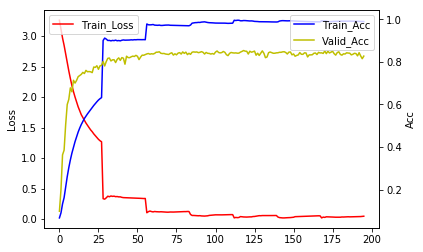

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(loss_array, 'r')
ax1.legend(['Train_Loss'], loc=2)
ax1.set_ylabel('Loss')


ax2 = ax1.twinx()
ax2.plot(train_acc_array, 'b')
ax2.plot(valid_acc_array, 'y')
ax2.legend(['Train_Acc', 'Valid_Acc'], loc=1)
ax2.set_ylabel('Acc')

plt.savefig('./train.png',dpi=500)

fig.show()